# Search Algorithms for Text Adventure Games

In this Python notebook, we will walk through how to use search algorithms like Breadth-First Search (BFS) to solve our text adventure games like Action Castle.

In order to do so, we'll need to figure out:
1. How to represent the __state space__ for the game.
2. How to list the __possible moves__ at each turn in the game.
3. How to use each possible move to generate a __successor state__.
4. How to test whether we have reached __the goal__.

To get started with this assignment, you can choose `Runtime > Run all` from the menu, and then jump to the section called "START HERE: Implement these functions".

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [1]:
from collections import defaultdict
import io
import sys
import os

print_to_stdout = False
print_to_devnull = True

if print_to_stdout:
  game_io = sys.stdout
elif print_to_devnull:
  game_io = open(os.devnull, 'w')
else:
  game_io = io.StringIO()

def print_game_output(*args, **kwargs):
  kwargs['file'] = game_io
  print(*args, **kwargs)


In [2]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at, all_locations):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    self.all_locations = all_locations
    # inventory is the set of objects that the player has collected
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print_game_output(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print_game_output("Exits: ", end = '')
      print_game_output(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print_game_output("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print_game_output(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print_game_output('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [3]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # The properties should contain a key "end_game" with value True
    # if entering this location should end the game
    self.properties = defaultdict(bool)
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False


  def set_property(self, property_name, property_bool=True):
    """Sets the property of this item"""
    self.properties[property_name] = property_bool
  
  def get_property(self, property_name):
    """Gets the boolean value of this property for this item (defaults to False)"""
    return self.properties[property_name]



  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    direction = direction.lower()
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""
    if direction == 'inside':
      connected_location.connections["outside"] = self
      connected_location.travel_descriptions["outside"] = ""
    if direction == 'outside':
      connected_location.connections["inside"] = self
      connected_location.travel_descriptions["inside"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [4]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("The %s isn't in this location" % item.name)
    # todo - add other types of preconditions
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [5]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    self.properties = defaultdict(bool)
    self.properties["gettable"] = True
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}

  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def set_property(self, property_name, property_bool=True):
    """Sets the property of this item"""
    self.properties[property_name] = property_bool
  
  def get_property(self, property_name):
    """Gets the boolean value of this property for this item (defaults to False)"""
    return self.properties[property_name]


  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
    else:
      print_game_output("Cannot perform the action %s" % command_text)
    return end_game

## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [6]:
# import io
# fake_file = io.StringIO()

class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.
    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print_game_output("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)
    print_game_output("*", direction)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print_game_output(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.get_property('end_game'):
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print_game_output("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.get_property('end_game')

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print_game_output("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print_game_output("You have: " + ", ".join(descriptions))
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print_game_output(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print_game_output(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print_game_output("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.get_property('gettable'):
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print_game_output(item.take_text)
          end_game = item.get_property('end_game')
        else:
          print_game_output("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print_game_output("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print_game_output("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print_game_output("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print_game_output("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)


  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None


## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [7]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print_game_output(action_description)
    game.add_to_inventory(item)
  else:
    print_game_output(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print_game_output(description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print_game_output(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print_game_output(action_description)
  else:
    print_game_output(already_done_description)
  return False

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print_game_output(end_message)
  return True

In [8]:
# Special functions
def perform_multiple_actions(game, *args):
  """Iterates over a list of special functions and performs each one."""
  (list_of_function_arguments_tuples) = args[0]
  for (function, arguments) in list_of_function_arguments_tuples:
    function(game, arguments)

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description, already_done_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print_game_output(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print_game_output(action_description)
  else:
    print_game_output(already_done_description)

def create_item(game, *args):
  """Places an Item at this location."""
  (item, action_description) = args[0]
  game.curr_location.add_item(item.name, item)
  print_game_output(action_description)


# Special functions
def perform_multiple_actions(game, *args):
  """Iterates over a list of special functions and performs each one."""
  (list_of_function_arguments_tuples) = args[0]
  for (function, arguments) in list_of_function_arguments_tuples:
    function(game, arguments)

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description, already_done_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print_game_output(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print_game_output(action_description)
  else:
    print_game_output(already_done_description)

def create_item(game, *args):
  """Places an Item at this location."""
  (item, action_description) = args[0]
  game.curr_location.add_item(item.name, item)
  print_game_output(action_description)

def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("The %s isn't in this location" % item.name)
    if check == "location_does_not_have_item":
      item = preconditions[check]
      if item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print_game_output("There is a %s in this location" % item.name)
    # todo - add other types of preconditions, like whether we're in a certain location
  return all_conditions_met


## Game Data

Here's an implementation of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  


In [9]:

def build_game():
  # Locations
  cottage = Location("Cottage", "You are standing in a small cottage.")
  garden_path = Location("Garden Path", "You are standing on a lush garden path. There is a cottage here.")
  fishing_pond = Location("Fishing Pond", "You are at the edge of a small fishing pond.")
  winding_path = Location("Winding Path", "You are walking along a winding path. There is a tall tree here.")
  top_of_tree = Location("Top of the Tall Tree", "You are the top of the tall tree.")
  drawbridge = Location("Drawbridge", "You are standing on one side of a drawbridge leading to ACTION CASTLE.")
  courtyard = Location("Courtyard", "You are in the courtyard of ACTION CASTLE.")
  tower_stairs = Location("Tower Stairs", "You are climbing the stairs to the tower. There is a locked door here.")
  tower = Location("Tower", "You are inside a tower.")
  dungeon_stairs = Location("Dungeon Stairs", "You are climbing the stairs down to the dungeon.")
  dungeon = Location("Dungeon", "You are in the dungeon. There is a spooky ghost here.")
  feasting_hall = Location("Great Feasting Hall", "You stand inside the Great Feasting Hall.")
  throne_room = Location("Throne Room", "This is the throne room of ACTION CASTLE.")

  death = Location("The Afterlife", "You are dead. GAME OVER.")
  death.set_property('end_game', True)
  nowhere = Location("nowhere", "Nowhere")
#  death.add_connection("south", nowhere)

  locations = [
    cottage, garden_path, fishing_pond, winding_path, top_of_tree,
    drawbridge, courtyard, tower_stairs, tower, dungeon_stairs, 
    dungeon, feasting_hall, throne_room, death, nowhere,
  ]


  # Connections
  cottage.add_connection("out", garden_path)
  garden_path.add_connection("south", fishing_pond)
  garden_path.add_connection("north", winding_path)
  winding_path.add_connection("up", top_of_tree)
  top_of_tree.add_connection("jump", death)
  winding_path.add_connection("east", drawbridge)
  drawbridge.add_connection("east", courtyard)
  courtyard.add_connection("up", tower_stairs)
  tower_stairs.add_connection("up", tower)
  courtyard.add_connection("down", dungeon_stairs)
  dungeon_stairs.add_connection("down", dungeon)
  courtyard.add_connection("east", feasting_hall)
  feasting_hall.add_connection("east", throne_room)


  # Items that you can pick up
  fishing_pole = Item("pole", "a fishing pole", "A SIMPLE FISHING POLE.", start_at=cottage)
  rosebush = Item("rosebush", "a rosebush", "THE ROSEBUSH CONTAINS A SINGLE RED ROSE.  IT IS BEAUTIFUL.", start_at=garden_path)
  rose = Item("rose", "a red rose", "IT SMELLS GOOD.", start_at=nowhere)
  fish = Item("fish", "a dead fish", "IT SMELLS TERRIBLE.", start_at=nowhere)
  branch = Item("branch", "a stout, dead branch", "IT LOOKS LIKE IT WOULD MAKE A GOOD CLUB.", start_at=top_of_tree)
  locked_door = Item("locked door", "a locked door", "THE DOOR IS SECURELY LOCKED.", start_at=tower_stairs)
  unlocked_door = Item("unlocked door", "a door", "THE DOOR IS UNLOCKED.", start_at=nowhere)
  lamp = Item("lamp", "a lamp (unlit)", "A LAMP.", start_at=nowhere)
  lit_lamp = Item("lamp (lit)", "a lamp (lit)", "A BIGHTLY LIT LAMP.", start_at=nowhere)
  candle = Item("candle", "a strange candle", "THE CANDLE IS COVERED IN STARGE RUNES.", start_at=feasting_hall)
  lit_candle = Item("candle (lit)", "a lit candle", "THE CANDLE IS COVERED IN STARGE RUNES.  IT IS EMITTING A STRANGE, ACRID SMELLING SMOKE.", start_at=nowhere)
  crown = Item("crown", "a crown", "A CROWN FIT FOR A KING.", start_at=nowhere)
  crown_worn = Item("crown (worn)", "a crown", "A CROWN FIT FOR A KING.", start_at=nowhere)

  # Sceneary and People (things that you can not pick up)
  pond = Item("pond", "a small fishing pond", "THERE ARE FISH IN THE POND.", start_at=fishing_pond)
  troll = Item("troll", "a mean troll", "HE LOOKS HUNGRY.", start_at=drawbridge)
  guard = Item("guard", "a guard carrying a sword and a key", "HE LOOKS AT YOU SUSPICIOUSLY.", start_at=courtyard)
  key = Item("key", "a brass key", "THIS LOOKS USEFUL.", start_at=nowhere)
  unconscious_guard = Item("unconscious guard", "an unconscious guard is slumped against the wall", "HE HAS BITS OF BRANCH ON HIS UNIFORM.", start_at=nowhere)

  sad_princess = Item("princess (sad)", "A princess who is beautiful, sad and lonely. She awaits her non-gender-stereotypical soulmate.", start_at=tower)
  princess = Item("princess", "A princess who is beautiful and lonely. She awaits her non-gender-stereotypical soulmate.", start_at=nowhere)
  married_princess = Item("princess (married)", "A princess  who is beautiful. She has found her non-gender-stereotypical soulmate.", start_at=nowhere)
  # TODO - NEED A NOTION OF TIME IN A LOCATION FOR THIS: The ghost will reach out for the player to stop his heart if the player lingers here.
  ghost = Item("ghost", "A ghost with bony, claw-like fingers and who is wearing a crown.", start_at=dungeon)
  throne = Item("throne", "An ornate golden throne.", start_at=throne_room)

  pond.set_property("gettable", False)
  troll.set_property("gettable", False)
  guard.set_property("gettable", False)
  unconscious_guard.set_property("gettable", False)
  locked_door.set_property("gettable", False)
  unlocked_door.set_property("gettable", False)
  sad_princess.set_property("gettable", False)
  princess.set_property("gettable", False)
  married_princess.set_property("gettable", False)
  guard.set_property("gettable", False)
  ghost.set_property("gettable", False)
  throne.set_property("gettable", False)
  

  # Add special functions to your items
  rosebush.add_action("pick rose",  add_item_to_inventory, (rose,"You pick the lone rose from the rosebush.","You already picked the rose."))
  rose.add_action("smell rose",  describe_something, ("It smells sweet."))
  rosebush.add_action("pick rose",  add_item_to_inventory, (rose,"You pick the lone rose from the rosebush.","You already picked the rose."))
  pond.add_action("catch fish",  describe_something, ("You reach into the pond and try to catch a fish with your hands, but they are too fast."))
  pond.add_action("catch fish with pole",  add_item_to_inventory, (fish,"You dip your hook into the pond and catch a fish.","You weren't able to catch another fish."), preconditions={"inventory_contains":fishing_pole})
  fish.add_action("eat fish",  describe_something, ("That's disgusting! It's raw! And definitely not sashimi-grade!"))
  troll.add_action("hit troll with branch", destroy_item, (branch,"You swing your branch against the troll. It shatters to pieces. The troll looks angry now.","You already tried that."), preconditions={"inventory_contains":branch , "location_has_item": troll})
#  troll.add_action("give fish to troll", destroy_item, (troll,"You give the fish to the troll and it scampers away.","You already gave the fish to the troll."), preconditions={"inventory_contains":fish, "location_has_item": troll})

  troll.add_action("give the troll the fish", 
                   perform_multiple_actions, 
                   ([(destroy_item, (fish,"You give the troll your fish, which is promptly eaten.","You already tried that.")), 
                     (destroy_item, (troll,"The now happy troll runs off.",""))]), 
                   preconditions={"inventory_contains":fish , "location_has_item": troll})

  guard.add_action("hit guard with branch", perform_multiple_actions, ([(destroy_item, (branch,"You swing your branch against the guard. It shatters to pieces.","You already tried that.")),
                                                                        (destroy_item, (guard,"The guard slumps over, unconscious.","")),
                                                                        (create_item, (unconscious_guard,"The guard's unconscious body lies on the ground.")),
                                                                        (create_item, (key,"His key falls from his hand.")),
                                                                      ]), preconditions={"inventory_contains":branch , "location_has_item": guard})
  locked_door.add_action("unlock door", perform_multiple_actions, ([(destroy_item, (locked_door,"You slide the key into the the keyhole.","You already unlocked the door.")),
                                                                        (create_item, (unlocked_door,"The key turns with a click. The door is now unlocked")),
                                                                      ]), preconditions={"inventory_contains":key , "location_has_item": locked_door})
  lamp.add_action("light lamp", perform_multiple_actions, ([(destroy_item, (lamp,"You light the lamp's whick.","It is already lit.")),
                                                            (add_item_to_inventory, (lit_lamp,"It starts to glow brightly.","")),
                                                            ]), preconditions={"inventory_contains":lamp})
  candle.add_action("light candle", perform_multiple_actions, ([(destroy_item, (candle,"You light the candle's whick.","It is already lit.")),
                                                                (add_item_to_inventory, (lit_candle,"It starts to emit a strange, acrid smelling smoke.","")),
                                                            ]), preconditions={"inventory_contains":candle})
  candle.add_action("read runes",  describe_something, ("The runes seem to be a spell of exorcism."))
  lit_candle.add_action("read runes", perform_multiple_actions, ([(destroy_item, (ghost,"You read aloud the runes on the candle. The runes seem to be a spell of exorcism.","")),
                                                                  (create_item, (crown,"The ghost drops its crown as it flees.")),
                                                                 ]), preconditions={"location_has_item":ghost, "inventory_contains":lit_candle})


  sad_princess.add_action("give rose to princess", perform_multiple_actions, ([(destroy_item, (rose,"You hand the rose to the princess.","You already did that.")),
                                                                        (destroy_item, (sad_princess,"She smiles at you.","")),
                                                                        (create_item, (princess,"She looks eager to talk.")),
                                                                      ]), preconditions={"inventory_contains":rose , "location_has_item": sad_princess})
  sad_princess.add_action("talk to princess",  describe_something, ("She is too sad to talk to you."))
  sad_princess.add_action("kiss princess",  describe_something, ("She slaps you"))
  princess.add_action("talk to princess",  describe_something, ("What would you like to talk to the princess about? (the ghost, the crown, the throne)."))
  princess.add_action("talk to princess about the ghost",  describe_something, ("She says, 'My father haunts the dungeon as a restless spirit.'"))
  princess.add_action("talk to princess about the crown",  describe_something, ("She says, 'Only the rightful heir to the throne may wear it!'"))
  princess.add_action("talk to princess about herself",  describe_something, ("She says, 'I cannot leave this tower until I am married!'"))
  princess.add_action("talk to princess about the throne",  describe_something, ("She says, 'Only the king may sit on the throne'"))
  princess.add_action("propose to the princess", perform_multiple_actions, ([(destroy_item, (princess,"'My father’s crown! You have put his soul at rest and may now succeed him!'","")),
                                                                        (create_item, (married_princess,"She happily accepts your marriage proposal. You may now wear the crown.")),
                                                                      ]), preconditions={"inventory_contains":crown , "location_has_item": princess})
  princess.add_action("kiss princess",  describe_something, ("'Not until we're wed.'"))
  married_princess.add_action("kiss princess",  describe_something, ("She kisses you back. It's very romantic."))


  crown.add_action("wear crown", perform_multiple_actions, ([(destroy_item, (crown,"The princess places the crown on your head","")),
                                                                        (add_item_to_inventory, (crown_worn,"You are now wearing the crown.","")),
                                                                      ]), preconditions={"inventory_contains":crown , "location_has_item": married_princess})

  throne.add_action("sit on throne", describe_something, ("You sit on the ornate golden throne with the princess by your side. The throne room fills with courtiers, guards, and other subjects.  The people cheer for the new ruler of... ACTION CASTLE! Congratulations, you win the game!"), preconditions={"inventory_contains":crown_worn})




  # Add blocks to a location
  drawbridge.add_block("east", "The troll blocks your way.", preconditions={"location_does_not_have_item": troll})
  courtyard.add_block("east", "The guard refuses to let you pass.", preconditions={"location_does_not_have_item": guard})
  tower_stairs.add_block("up", "The door is locked.", preconditions={"location_does_not_have_item": locked_door})
  dungeon_stairs.add_block("down", "It's too dark to see.", preconditions={"inventory_contains": lit_lamp})
  


  game = Game(cottage, locations)
  game.add_to_inventory(lamp)
  return game

# Run the game
#game_loop()



## Play the Game

In [10]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return

#game_loop()
#print_game_output('THE GAME HAS ENDED.')

## Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

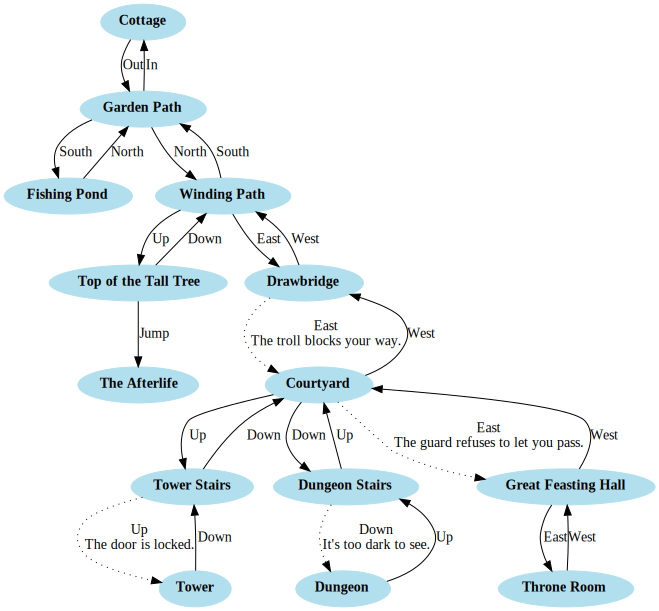

In [11]:
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def BFS(game, graph):
  """Do a breadth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
#    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    html = "<<b>%s</b>>" % (name)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
BFS(game, graph)
#save_to_drive(graph)
graph


# START HERE: Implement these functions



In [12]:
def get_state(game):
  """ 
  Create a representation of the game's state. 
  Your representation must be immutable so that it can 
  be used as a key in a Python dictionary.
  """
  state_description = []
  # Current location
  state_description.append("Current Location: " + game.curr_location.name)
#  TODO: implement a full state representation
  return tuple(state_description)



def get_available_actions(game):
  """
  Create a list all of the available actions from the current state of the game.
  This should be a list of commands (string) that can be individually executed 
  by the game's parser.
  """
  actions = []
  # Go in a direction
  for direction in game.curr_location.connections.keys():
    actions.append("go " + direction)
#  TODO: get other actions (you should skip the 'drop' action)
  return actions



def goal_test(game, goal_conditions):
  """
  Checks whether the current game meets the set of 
  goal conditions. The goal_conditions data structure 
  is a dictionary with key names like "at_location" or
  "inventory_contains" and the values are the names of 
  that location or that item.  For instance you could initalize 
  it like this:
  ```
  goal_conditions = {"at_location" : "Throne Room",
                     "inventory_contains" : "crown (worn)"}
  ```
  """
  for check in goal_conditions: 
    if check == "at_location":
      location_name = goal_conditions[check]
      if not location_name == game.curr_location.name:
        return False
    elif check == "something else":
      # TODO Add your checks here.
      pass
    else:
      raise NotImplementedError
  # All conditions have been met
  return True

# Breadth-First Search Algorithm

In [19]:
import copy
from collections import defaultdict

def BFS(game, goal_conditions):
  """
  Do a breadth-first-search traversal of the game, enumerating all
  possible game commands that can be executed at each state.
  """
  # The frontier is a FIFO queue
  frontier = queue.Queue()
  command_sequence = []

  # On the queue, we'll keep place a tuple containing the current game, 
  # and the sequence of commands that were executed to get to this state
  # of the game.
  frontier.put((game, command_sequence))

  # The visited dictionary stores a list of game states that 
  # we have already been to so that we don't repeatedly visit the same state.
  # Note: You'll have to implement get_state() to return an immutable 
  # state representation, so that it can be used a dictionary key.
  visited = dict()
  visited[get_state(game)] = True
  
  # We'll check whether the start state itself meets the goal test.
  # If so, we don't need to do anything.
  if goal_test(game, goal_conditions):
    return command_sequence

  # We'll keep track of some statistics about the search: 
  # depth, number of nodes expanded, and number of nodes skipped 
  num_expanded = 0
  num_trimmed = 0
  current_depth = 0
  branching_count = 0
  max_branching_factor = 0
  max_actions_list = []

  # Perform the search
  while not frontier.empty():
    (current_game, command_sequence) = frontier.get()
    current_state = get_state(current_game)
    parser = Parser(current_game)
    # Note: Implement get_available_actions() to list the possible
    # moves that can be made from the current state of the game.
    available_actions = get_available_actions(current_game)

    num_actions = len(available_actions)
    branching_count += num_actions
    if num_actions > max_branching_factor:
      max_branching_factor = num_actions
      max_actions_list = available_actions.copy()

    num_expanded += 1

    for command in available_actions:
      # Clone the current game with its state
      new_game = copy.deepcopy(current_game)
      # Apply the command to it to get the resulting state
      parser = Parser(new_game)
      parser.parse_command(command)
      new_state = get_state(new_game)
      # Update the sequence of actions that we took to get to the resulting state
      new_command_sequence = copy.copy(command_sequence)
      new_command_sequence.append(command)

      # Print some statistics about the search
      if len(new_command_sequence) > current_depth:
        current_depth = len(new_command_sequence)
        print("Starting on depth {depth}.".format(depth = current_depth))
        print("Expanded {expanded} nodes. Trimmed {trimmed} nodes.".format(
            expanded=num_expanded, trimmed=num_trimmed)) 
        print("There are {num_on_frontier} nodes on the frontier.".format(num_on_frontier=frontier.qsize()))
        avg_branching_factor = branching_count/num_expanded
        print("The average branching factor is {avg_branching_factor:.2f} (max {max_branching_factor}).".format(
            avg_branching_factor=avg_branching_factor, max_branching_factor=max_branching_factor))
        print("Longest list of available actions: ", max_actions_list)

        print("---")

      # Check whether we have visited this state already.  If so, skip it.
      if not new_state in visited:
        visited[new_state] = True
        if goal_test(new_game, goal_conditions):
          print("Found solution at depth {depth}.".format(depth = current_depth))
          print("Expanded {expanded} nodes. Trimmed {trimmed} nodes.".format(
              expanded=num_expanded, trimmed=num_trimmed)) 
          print("There are {num_on_frontier} nodes on the frontier.".format(num_on_frontier=frontier.qsize()))
          print("The average branching factor is {avg_branching_factor:.2f} (max {max_branching_factor}).".format(
            avg_branching_factor=avg_branching_factor, max_branching_factor=max_branching_factor))
          print("Longest list of available actions: ", max_actions_list)


          print("---")
          return new_command_sequence
        frontier.put((new_game, new_command_sequence))
      else: 
        num_trimmed += 1

  # If we have removed all nodes from the frontier without finding one that 
  # passes the goal test then there is no solution. 
  print("No solution was found.")
  print("There are {num_on_frontier} nodes on the frontier.".format(num_on_frontier=frontier.qsize()))
  print("Explored to at depth {depth}.".format(depth = current_depth))
  print("Expanded {expanded} nodes. Trimmed {trimmed} nodes.".format(
        expanded=num_expanded, trimmed=num_trimmed)) 
  print("The average branching factor is {avg_branching_factor:.2f} (max {max_branching_factor}).".format(
        avg_branching_factor=avg_branching_factor, max_branching_factor=max_branching_factor))
  print("Longest list of available actions: ", max_actions_list)
  print("---")
  # Return None to indicate there is no solution.
  return None



In [ ]:
goal_conditions = {"at_location" : "Drawbridge",}

# See if you can find a solution that meets these goals too.
goal_conditions = {"at_location" : "Tower",}
#goal_conditions = {"inventory_contains" : "fish",}
#goal_conditions = {"at_location" : "Throne Room", "inventory_contains" : "crown (worn)"}

game = build_game()
solution = BFS(game, goal_conditions)
print("SOLUTION:", solution)
